In [1]:
import numpy as np
import scipy.special as sp
import scipy.integrate
from domain_class import domain
from Multipoles import Multipoles
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

class focused_beams(Multipoles):
    def __init__(self, type, maxJ, wl, domain, nr=1, NA=0.9, f=1000, n_lens = 1):
        super().__init__(maxJ, maxJ, wl, domain, nr)
        self.NA = NA
        self.f = f
        self.wn = 2 * np.pi / wl
        self.type = type
        self.beam_types = ["LaguerreGauss", "Bessel", "PlaneWave"]
        self.domain = domain
        self.size = domain.size
        self.planes = self.spherical_grids.keys()
        self.n_lens = n_lens
        self.maxJ = maxJ
        
        # initialize arrays of spherical coordinates. shape = (Nplanes, shape(grid))
        self.R = np.array([self.spherical_grids[plane][0] for plane in self.planes])
        self.Theta = np.array([self.spherical_grids[plane][1] for plane in self.planes])
        self.Phi = np.array([self.spherical_grids[plane][2] for plane in self.planes])
        
        try:
            self.beam = self.init_beam(type)
        except ValueError as e:
            print(e)

    def init_beam(self, type):
        if type == "LaguerreGauss":
            return self.LaguerreGauss
        elif type == "Bessel":
            return self.Bessel
        elif type == "PlaneWave":
            return self.PlaneWave
        else:
            raise ValueError("Beam type not recognized")

    def Bessel(self, q, l, w, wl, z0, rho, z, **kwargs):
        # Implement Bessel beam calculation here
        pass

    def PlaneWave(self, q, l, w, wl, z0, rho, z, **kwargs):
        # Implement PlaneWave beam calculation here
        pass

    def d_jmp(self, j, m, p, Theta):
        lnCoef = 0.5 * (sp.gammaln(j - m + 1) + sp.gammaln(j + m + 1) - sp.gammaln(j + p + 1) - sp.gammaln(j - p + 1))
        cosFac = np.cos(Theta / 2) ** (m + p)
        sinFac = (-np.sin(Theta / 2)) ** (m - p)
        
        n = j - m
        alpha = m - p
        beta = m + p
        hyp = sp.eval_jacobi(n, alpha, beta, np.cos(Theta))
        
        d_jmp = np.exp(lnCoef) * cosFac * sinFac * hyp
        
        return d_jmp

    def C_jlp(self, l, p, q):
        assert self.maxJ >= abs(l)+p, "maxJ must be greater than or equal to abs(l)+p"
        
        wn = 2 * np.pi / self.wl
        m = l + p
        theta_max = np.arcsin(self.NA / self.n_lens)  # maximum half angle
        theta = np.linspace(0.0001, theta_max, 250)
        
        # Generalize beam calculation
        beam_params = {
            'q': q,
            'l': l,
            'rho': self.f * np.sin(theta),
            'z': self.f
        }
        beamfac = self.beam(**beam_params)
        
        
        #LG = self.beam(q, l, w, wl, z0, f * np.sin(theta), f)
        
        lensInt = scipy.integrate.trapezoid(self.f**2 * 2 * np.pi * np.sin(theta) * np.cos(theta) * (beamfac**2), theta)
        
        C = np.zeros(self.maxJ + 1, dtype=complex)
        suma = 0
        for j in range(max(abs(m), 1), self.maxJ+1):
            C[j] = scipy.integrate.trapezoid(
                np.sin(theta) *
                self.f * np.exp(-1j * wn * self.f) *
                np.sqrt(2 * np.pi) *
                np.sqrt(self.n_lens * np.cos(theta)) *
                beamfac *
                self.d_jmp(j, m, p, theta), theta
            )
            suma += np.abs(C[j])**2 * (2 * j + 1)
        
        return C, lensInt, suma

    def LaguerreGauss(self, q, l, rho, z, **kwargs):
        wn = 2 * np.pi / self.wl  # wavenumber
        w = self.get_w(self.NA, l)
        print(w)

        z0 = self.n_lens * w / self.NA  # Rayleigh distance
        logN = lambda l, q: 0.5 * (sp.gammaln(q + 1) - sp.gammaln(q + l + 1) - np.log(np.pi))
        bracket = 1j * (-(wn * rho**2 * z) / (2 * (z**2 + z0)) + (2 * q * l + 1) * np.arctan(z / z0))
        
        l = abs(l)
        L = sp.genlaguerre(q, l)(2 * rho**2 / (w**2))
        logLG = logN(l, q) - rho**2 / (w**2) + l * np.log(rho) + (l + 1) * (0.5 * np.log(2) - np.log(w))
        LG = np.exp(logLG) * L
        
        return LG

    def Bessel(self, q, l, w, wl, z0, rho, z, **kwargs):
        # Implement Bessel beam calculation here
        pass

    def PlaneWave(self, q, l, w, wl, z0, rho, z, **kwargs):
        # Implement PlaneWave beam calculation here
        pass

    def d_jmp(self, j, m, p, Theta):
        lnCoef = 0.5 * (sp.gammaln(j - m + 1) + sp.gammaln(j + m + 1) - sp.gammaln(j + p + 1) - sp.gammaln(j - p + 1))
        cosFac = np.cos(Theta / 2) ** (m + p)
        sinFac = (-np.sin(Theta / 2)) ** (m - p)
        
        n = j - m
        alpha = m - p
        beta = m + p
        hyp = sp.eval_jacobi(n, alpha, beta, np.cos(Theta))
        
        d_jmp = np.exp(lnCoef) * cosFac * sinFac * hyp
        
        return d_jmp
    
    def get_w(self, NA, l):
        w_values = {
            0.3: [170, 144, 130, 121, 113, 106, 101, 97, 94],
            0.5: [270, 236, 216, 200, 186, 178, 170, 162, 155],
            0.9: [500, 420, 390, 360, 335, 290, 317, 303, 290]
        }
        
        if NA not in w_values:
            raise ValueError("NA value not recognized. Available values are 0.3, 0.5, 0.9.")
        
        if l < 0 or l >= len(w_values[NA]):
            raise ValueError("l value out of range.")
        
        return w_values[NA][l]
    
    
    def compute_sum(self, l, p, q, spatial_fun = "bessel"):
        C, lensInt, suma = self.C_jlp(l, p, q)
        #print("The (2j+1)Cjm_z normalization yields %.3f" % suma)
        #print("The LG integral on the aplanatic lens surface is %.3f" % lensInt)
        
        m = l + p
        
        j0 = max(abs(m), 1)
        print(m, l, p, j0)
        mp0 = self.get_multipoles(j0, m, spatial_fun)

        mp0["magnetic"] *= C[j0]*(1j)**j0 * np.sqrt(2*j0+1)
        mp0["electric"] *= C[j0]*(1j)**j0 * np.sqrt(2*j0+1)
        """
        for j in range(j0+1, self.maxJ+1):
            mp = self.get_multipoles(j, m, spatial_fun)
            
            mp0["magnetic"] += (1j)**j * np.sqrt(2*j+1) * C[j] * mp["magnetic"]
            mp0["electric"] += (1j)**j * np.sqrt(2*j+1) * C[j] * mp["electric"]
        """    
        sum = mp0["magnetic"]#+(1j)*p*mp0["electric"]
        print(f"Sum shape: {sum.shape}")
        return self.get_multipoles(j0, m, spatial_fun)["magnetic"]

    def plot_beam(self, l, p, q, interaction="scattering", plot="components", globalnorm=False):
        """Plot the computed sum of multipoles.

        Args:
            l (int): Orbital angular momentum quantum number.
            p (int): Azimuthal quantum number.
            q (int): Radial quantum number.
            maxJ (int): Maximum value of the total angular momentum quantum number.
            interaction (str, optional): The desired interaction to visualize. Can either be 'scattering' or 'internal', which will show the field respectively outside or inside 
                                a central region. Defaults to "scattering".
            plot (str, optional): Plot full intensity or each polarization component. Defaults to "components".
            globalnorm (bool, optional): Normalize each plot to its own max (see individual behavior) or global max (see which components dominate). Defaults to False.

        Raises:
            ValueError: interaction must be 'scattering', 'internal' or 'both'
            ValueError: plot must be 'components' or 'total'
        """
        
        assert interaction in ["scattering", "internal", "both"], "interaction must be 'scattering' or 'internal'"
        assert plot in ["components", "total"], "plot must be 'components' or 'total'"
        
        rr = 0.25 * self.size  # Define the radius of the sphere
        
        # Initialize SCA and ABS arrays with ones, same shape as R
        SCA = np.ones_like(self.R)
        ABS = np.ones_like(self.R)
        
        # Find indices where values are less than or greater than rr
        index1 = np.where(self.R < rr)
        index2 = np.where(self.R > rr)

        # Set values in ABS and SCA arrays based on indices
        ABS[index2] = 0
        SCA[index1] = 0
        
        if interaction == "scattering":
            spatial_fun = "hankel"
            S = SCA
        elif interaction == "internal":
            spatial_fun = "bessel"
            S = ABS
        elif interaction == "both":
            spatial_fun = "bessel"
            S = np.ones_like(self.R)
        else:
            raise ValueError("interaction must be 'scattering' or 'internal'")
        
        sum = self.compute_sum(l, p, q, spatial_fun)
        
        if plot == "components":
            # Plot Nself.planes x 3 subplots
            fig, axs = plt.subplots(len(self.planes), 3, figsize=(12, 4 * len(self.planes)))
            
            sum[:] = np.abs(sum[:])**2 * S
            if globalnorm:
                # Find the global min and max values for normalization
                vmin = np.min(np.abs(sum[:])) 
                vmax = np.max(np.abs(sum[:]))
                norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            else:
                norm = None
                
            fig.suptitle(f'Computed Sum (l={l}, p={p}, q={q})', fontsize=24, fontweight='bold')
            for i, plane in enumerate(self.planes):

                im0 = axs[i, 0].imshow(np.abs(sum[0][i]).T, extent=(-self.size, self.size, -self.size, self.size), origin='lower', cmap='hot', norm=norm)  
                axs[i, 0].set_title(r'$\xi_1$')
                axs[i, 0].set_xlabel(plane[0]+" [µm]")
                axs[i, 0].set_ylabel(plane[1]+" [µm]")
                axs[i, 0].tick_params(axis='both', which='both', direction='in')
                divider0 = make_axes_locatable(axs[i, 0])
                cax0 = divider0.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im0, cax=cax0)

                im1 = axs[i, 1].imshow(np.abs(sum[1][i]).T, extent=(-self.size, self.size, -self.size, self.size), origin='lower', cmap='hot', norm=norm)
                axs[i, 1].set_title(r'$\xi_0$')
                axs[i, 1].set_xlabel(plane[0]+" [µm]")
                axs[i, 1].set_ylabel(plane[1]+" [µm]")
                axs[i, 1].tick_params(axis='both', which='both', direction='in')
                divider1 = make_axes_locatable(axs[i, 1])
                cax1 = divider1.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im1, cax=cax1)

                im2 = axs[i, 2].imshow(np.abs(sum[2][i]).T, extent=(-self.size, self.size, -self.size, self.size), origin='lower', cmap='hot', norm=norm)
                axs[i, 2].set_title(r'$\xi_{-1}$')
                axs[i, 2].set_xlabel(plane[0]+" [µm]")
                axs[i, 2].set_ylabel(plane[1]+" [µm]")
                axs[i, 2].tick_params(axis='both', which='both', direction='in')
                divider2 = make_axes_locatable(axs[i, 2])
                cax2 = divider2.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im2, cax=cax2)
            fig.subplots_adjust(hspace=-0.8, wspace=-0.2)
            fig.tight_layout()
            plt.show()
        
        elif plot == "total":
            # Plot self.planes x 1 subplots with the summed intensity of the three components
            fig, axs = plt.subplots(len(self.planes), 1, figsize=(12, 4 * len(self.planes)))

            # Sum the intensities of the three components
            total_intensity = np.sum(np.abs(sum)**2 * S, axis=0)

            if globalnorm:
                # Find the global min and max values for normalization
                vmin = np.min(total_intensity)
                vmax = np.max(total_intensity)
                norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
            else:
                norm = None

            fig.suptitle(f'Total Intensity (l={l}, p={p}, q={q})', fontsize=24, fontweight='bold')
            for i, plane in enumerate(self.planes):
                im = axs[i].imshow(total_intensity[i].T, extent=(-self.size, self.size, -self.size, self.size), origin='lower', cmap='hot', norm=norm)
                axs[i].set_title(f'{plane} plane')
                axs[i].set_xlabel(plane[0] + " [µm]")
                axs[i].set_ylabel(plane[1] + " [µm]")
                axs[i].tick_params(axis='both', which='both', direction='in')
                divider = make_axes_locatable(axs[i])
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)

            fig.subplots_adjust(hspace=-0.8, wspace=-0.2)
            fig.tight_layout()
            plt.show()


In [2]:
#initialize domain
size = 2
planes = {'xy', 'xz', 'yz'}
d = domain(size, planes)


#mp = Multipoles(5, 5, 0.632, d)
foc = focused_beams("LaguerreGauss", 25, 0.632, d, NA=0.9, f=1000, n_lens=1)

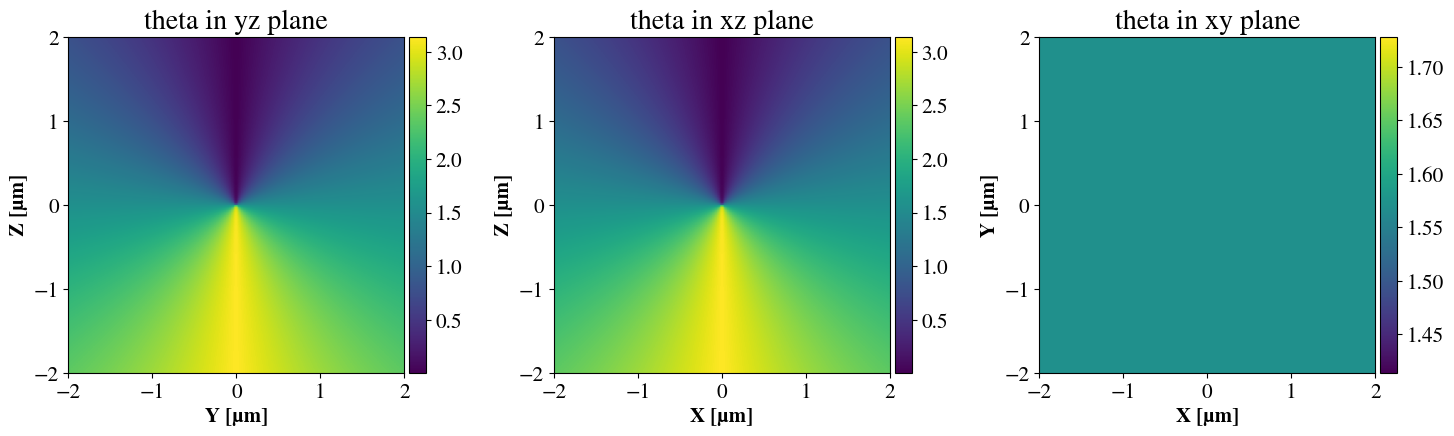

In [3]:
d.show_coord("theta", d.spherical_grid())

In [4]:
foc.C_jlp(2,1,0)[0][2+1]

390


(-0.02638811376534083-0.14588216559513037j)

In [5]:
foc.LaguerreGauss(0, 2, 1000*np.linspace(0.0001, np.arcsin(0.9), 10), 1000)

390


array([1.90222204e-10, 2.66311628e-04, 7.84246023e-04, 1.06043574e-03,
       9.24451753e-04, 5.77915996e-04, 2.71652704e-04, 9.84726982e-05,
       2.79464640e-05, 6.27013031e-06])

In [6]:
Leg = foc.get_Legendre(25, 3, np.cos(foc.Theta))
Leg.shape

(26, 4, 3, 200, 200)

In [8]:
sum_PM = foc.compute_sum(2, 1, 0)

390
3 2 1 3
Sum shape: (3, 3, 200, 200)


In [16]:
sum_PM[0]

array([[[ 1.11505582e-18+2.04832432e-34j,
          1.11889474e-18-1.13022553e-20j,
          1.10084479e-18-2.23544826e-20j, ...,
         -1.10084479e-18-2.23544826e-20j,
         -1.11889474e-18-1.13022553e-20j,
         -1.11505582e-18+2.04832432e-34j],
        [ 1.11889474e-18+1.13022553e-20j,
          1.10077678e-18+2.02209415e-34j,
          1.06079534e-18-1.08247240e-20j, ...,
         -1.06079534e-18-1.08247240e-20j,
         -1.10077678e-18+2.02209415e-34j,
         -1.11889474e-18+1.13022553e-20j],
        [ 1.10084479e-18+2.23544826e-20j,
          1.06079534e-18+1.08247240e-20j,
          9.99333668e-19+1.83574617e-34j, ...,
         -9.99333668e-19+1.83574617e-34j,
         -1.06079534e-18+1.08247240e-20j,
         -1.10084479e-18+2.23544826e-20j],
        ...,
        [-1.10084479e-18+2.23544826e-20j,
         -1.06079534e-18+1.08247240e-20j,
         -9.99333668e-19-6.11915389e-35j, ...,
          9.99333668e-19-6.11915389e-35j,
          1.06079534e-18+1.08247240e-20j

500
1 0 1 1
Sum shape: (3, 3, 200, 200)


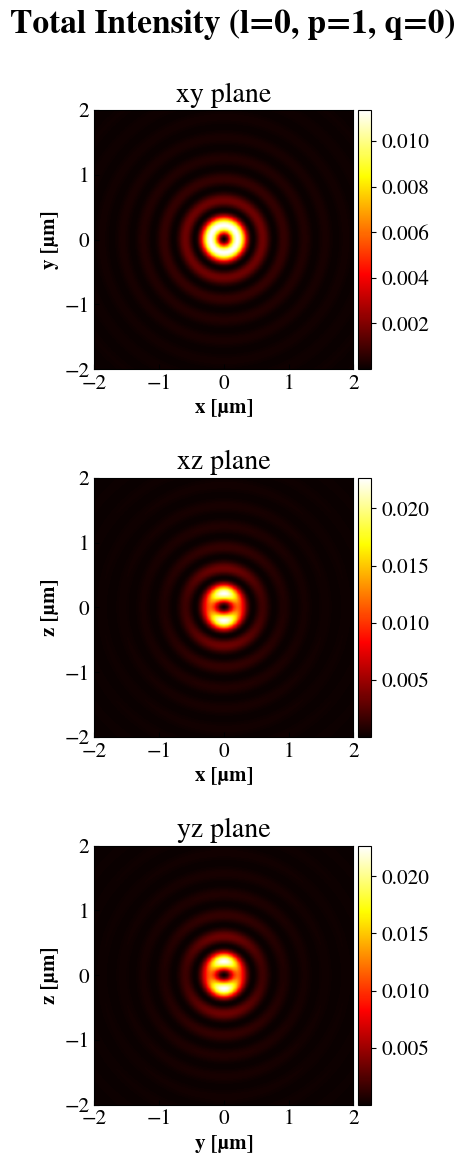

In [10]:
foc.plot_beam(0, 1, 0, interaction="both", plot="total", globalnorm=False)

In [11]:
foc.get_multipoles(3, 2+1, "bessel")["magnetic"]

array([[[[ 1.11505582e-18+2.04832432e-34j,
           1.11889474e-18-1.13022553e-20j,
           1.10084479e-18-2.23544826e-20j, ...,
          -1.10084479e-18-2.23544826e-20j,
          -1.11889474e-18-1.13022553e-20j,
          -1.11505582e-18+2.04832432e-34j],
         [ 1.11889474e-18+1.13022553e-20j,
           1.10077678e-18+2.02209415e-34j,
           1.06079534e-18-1.08247240e-20j, ...,
          -1.06079534e-18-1.08247240e-20j,
          -1.10077678e-18+2.02209415e-34j,
          -1.11889474e-18+1.13022553e-20j],
         [ 1.10084479e-18+2.23544826e-20j,
           1.06079534e-18+1.08247240e-20j,
           9.99333668e-19+1.83574617e-34j, ...,
          -9.99333668e-19+1.83574617e-34j,
          -1.06079534e-18+1.08247240e-20j,
          -1.10084479e-18+2.23544826e-20j],
         ...,
         [-1.10084479e-18+2.23544826e-20j,
          -1.06079534e-18+1.08247240e-20j,
          -9.99333668e-19-6.11915389e-35j, ...,
           9.99333668e-19-6.11915389e-35j,
           1.0607